# Modelos de Regresión - Distritos de Madrid

Este notebook implementa modelos de regresión para predecir el consumo eléctrico en los distritos de Madrid basándose en variables demográficas, socioeconómicas y ambientales.

## Objetivos:
- Integrar datos de múltiples fuentes (consumo, demografía, renta, clima, etc.)
- Entrenar y comparar diferentes modelos de regresión
- Evaluar el rendimiento de los modelos mediante validación cruzada
- Identificar las variables más importantes para predecir el consumo eléctrico


In [30]:
# %%
import os
import glob
import json
import sys
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Series temporales
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 200)
plt.style.use('seaborn-v0_8')

# Importar utilidades centralizadas
import sys
sys.path.append('src')
import os
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath(''))))
# O mejor, agregar el directorio actual (raíz del proyecto)
sys.path.insert(0, os.getcwd() if os.path.exists('config') else os.path.dirname(os.getcwd()))
from config.paths import DATA_PROCESSED, BASE_DIR

BASE_DIR = BASE_DIR
DATA_DIR = DATA_PROCESSED

print(f"Base: {BASE_DIR}")
print(f"Data: {DATA_DIR}")



Base: C:\Users\phoen\Desktop\TFM
Data: C:\Users\phoen\Desktop\TFM\data\processed


## Importación de Librerías

Importamos las librerías necesarias para el procesamiento de datos, modelado y visualización.

In [31]:
# Cargar datos de Madrid
print("🏙️ Buscando archivos para la carga de datos")

# Importar utilidades centralizadas
import sys
sys.path.append('src')
from config.paths import DATA_PROCESSED

# === CARGA DE DATOS PRINCIPALES ===
file_path = DATA_PROCESSED / 'madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx'

# Función para encontrar la ruta correcta por si no está en el directorio correcto
def encontrar_archivo(nombre_archivo):
    """Busca el archivo en el directorio actual y en el directorio padre"""
    from pathlib import Path
    nombre_archivo = Path(nombre_archivo)
    
    rutas_posibles = [
        nombre_archivo,
        Path.cwd() / nombre_archivo,
        Path.cwd().parent / nombre_archivo,
        DATA_PROCESSED / nombre_archivo.name,
        Path.cwd().parent / nombre_archivo,
        Path.cwd().parent.parent / nombre_archivo
    ]
    
    for ruta in rutas_posibles:
        if ruta.exists():
            return ruta
    return None

# Verificar si los archivos principales existen
archivos_madrid = [
    DATA_PROCESSED / 'madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx',
    DATA_PROCESSED / 'electricity_data_madrid.csv',
    DATA_PROCESSED / 'air_quality_madrid.csv',
    DATA_PROCESSED / 'mobility_data_madrid.csv',
    DATA_PROCESSED / 'weather_data_madrid.csv'
]

rutas_encontradas = {}
for archivo in archivos_madrid:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo.name} - Encontrado en: {ruta}")
        rutas_encontradas[str(archivo)] = ruta
    else:
        print(f"❌ {archivo.name} - No encontrado")

🏙️ Buscando archivos para la carga de datos
✅ madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx - Encontrado en: C:\Users\phoen\Desktop\TFM\data\processed\madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx
✅ electricity_data_madrid.csv - Encontrado en: C:\Users\phoen\Desktop\TFM\data\processed\electricity_data_madrid.csv
✅ air_quality_madrid.csv - Encontrado en: C:\Users\phoen\Desktop\TFM\data\processed\air_quality_madrid.csv
✅ mobility_data_madrid.csv - Encontrado en: C:\Users\phoen\Desktop\TFM\data\processed\mobility_data_madrid.csv
✅ weather_data_madrid.csv - Encontrado en: C:\Users\phoen\Desktop\TFM\data\processed\weather_data_madrid.csv


## 📊 Carga de Datos Principales

Cargamos los datos de consumo eléctrico, demografía y renta desde el archivo Excel principal.

**Hojas del Excel:**
- `Consumo`: Datos de consumo eléctrico por percentiles (p10, p25, p50, p75, p90)
- `Demografia`: Variables demográficas por distrito
- `Renta`: Variables de renta y nivel socioeconómico


In [32]:
print("🏙️ Carga de datos de Madrid (Consumo / Renta / Demografía)")

# Consumo eléctrico por distritos
archivo_consumo = 'data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx'
try:
    ruta_consumo = rutas_encontradas.get(archivo_consumo, archivo_consumo)
    # Cargar datos principales
    df_consumo = pd.read_excel(ruta_consumo, sheet_name='Consumo')
    df_demografia = pd.read_excel(ruta_consumo, sheet_name='Demografia')
    df_renta = pd.read_excel(ruta_consumo, sheet_name='Renta')
    consumo_features = [col for col in df_consumo.columns if col not in ['distrito_num']]
    print(f"📊 Características de consumo: {list(consumo_features)}")   
    demografia_features = [col for col in df_demografia.columns if col not in ['territorio', 'año']]
    print(f"📊 Características demográficas: {list(demografia_features)}")
    renta_features = [col for col in df_renta.columns if col not in ['territorio', 'año']]
    print(f"📊 Características de renta: {list(renta_features)}")

# Normalizar columnas
    for df in [df_consumo, df_demografia, df_renta]:
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    print(f"📊 Datos principales cargados:")
    print(f"  - Consumo: {df_consumo.shape}")
    print(f"  - Demografía: {df_demografia.shape}")
    print(f"  - Renta: {df_renta.shape}")

    for nombre, df in {
        "Consumo": df_consumo,
        "Demografía": df_demografia,
        "Renta": df_renta
    }.items():
        print(f"\n📘 {nombre}")
        print("-" * 40)
        print("Columnas:", list(df.columns))
        print("\nPrimeras filas:")
        print(df.head(3))  # primeras 3 filas
        print("\nTipos de datos:")
        print(df.dtypes)
        print("\nValores nulos por columna:")
        print(df.isna().sum())
        print("=" * 60)
    
except Exception as e:
    print(f"❌ Error cargando consumo eléctrico: {e}")

🏙️ Carga de datos de Madrid (Consumo / Renta / Demografía)
❌ Error cargando consumo eléctrico: [Errno 2] No such file or directory: 'data/processed/madrid_distritos_consumo_59532_CORREGIDO_V2.xlsx'


## 🌍 Carga de Datos Adicionales

Cargamos datos adicionales que enriquecen el análisis:
- **Precios eléctricos**: Precios de la electricidad
- **Calidad del aire**: Índices de contaminación
- **Movilidad**: Datos de transporte público
- **Tiempo**: Datos meteorológicos


In [33]:
print("🏙️ Carga de datos adicionales sintéticos")

# === CARGA DE ARCHIVOS PRINCIPALES ===
archivos = {
    "precios": "data/processed/electricity_data_madrid.csv",
    "aire": "data/processed/air_quality_madrid.csv",
    "movilidad": "data/processed/mobility_data_madrid.csv",
    "tiempo": "data/processed/weather_data_madrid.csv"
}

dfs = {}

try:
    for nombre, ruta in archivos.items():
        ruta_real = rutas_encontradas.get(ruta, ruta)
        print(f"\n🔹 Cargando {nombre} desde {ruta_real}...")

        if nombre == "precios":
            df = pd.read_csv(ruta_real)
            print(f"✅ Precios eléctricos cargados: {len(df)} registros")
        elif nombre == "aire":
            df = pd.read_csv(ruta_real)
            print(f"✅ Calidad del aire cargada: {len(df)} registros")
        elif nombre == "movilidad":
            df = pd.read_csv(ruta_real)
            print(f"✅ Movilidad cargada: {len(df)} registros")
        else:
            df = pd.read_csv(ruta_real)
            print(f"✅ {nombre.capitalize()} cargado: {len(df)} registros")

        # Normalización básica de columnas
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
        dfs[nombre] = df

    madrid_precios = dfs.get("precios", pd.DataFrame())
    madrid_aire = dfs.get("aire", pd.DataFrame())
    madrid_movilidad = dfs.get("movilidad", pd.DataFrame())
    madrid_tiempo = dfs.get("tiempo", pd.DataFrame())

    # Resumen básico
    print("\n📊 Resumen de datos de Madrid:")
    for nombre, df in dfs.items():
        print(f"  - {nombre.capitalize()}: {df.shape[0]} filas, {df.shape[1]} columnas")

    # Mostrar estructura si quieres una primera exploración
    for nombre, df in dfs.items():
        print(f"\n📘 {nombre.capitalize()}")
        print("-" * 40)
        print("Columnas:", list(df.columns))
        print("\nPrimeras filas:")
        print(df.head(3))  # primeras 3 filas
        print("\nTipos de datos:")
        print(df.dtypes)
        print("\nValores nulos por columna:")
        print(df.isna().sum())
        print("=" * 60)

except Exception as e:
    print(f"\n❌ Error cargando alguno de los archivos principales: {e}")
    print("   Intentando cargar datos adicionales mediante integrador...")

    # === CARGA DE DATOS ADICIONALES ===
    import sys
    sys.path.append('src')
    try:
        from data_integration import DataIntegration
        from weather_data_collector import WeatherDataCollector
        from electricity_prices_collector import ElectricityPricesCollector
        from air_quality_collector import AirQualityCollector
        from mobility_data_collector import MobilityDataCollector

        print("\n🔄 Cargando datos adicionales...")
        
        # Crear instancia del integrador
        integrator = DataIntegration()
        
        # Recopilar datos adicionales (últimos 30 días)
        additional_data = integrator.collect_all_additional_data(days_back=30)
        
        if additional_data:
            print(f"✅ Datos adicionales recopilados:")
            for data_type, df_add in additional_data.items():
                print(f"  - {data_type}: {len(df_add)} registros")
            
            # Calcular métricas adicionales
            additional_metrics = integrator.calculate_additional_metrics(additional_data)
            
            if additional_metrics:
                print(f"✅ Métricas adicionales calculadas:")
                for metric_type, df_metric in additional_metrics.items():
                    print(f"  - {metric_type}: {len(df_metric)} registros")
        
        datos_adicionales_disponibles = True
    
    except ImportError as e:
        print(f"⚠️ Módulos adicionales no disponibles: {e}")
        print("   Continuando sin datos adicionales...")
        datos_adicionales_disponibles = False
        additional_data = {}
        additional_metrics = {}

    print(f"\n📋 Estado de datos adicionales: {'✅ Disponibles' if datos_adicionales_disponibles else '❌ No disponibles'}")


🏙️ Carga de datos adicionales sintéticos

🔹 Cargando precios desde data/processed/electricity_data_madrid.csv...

❌ Error cargando alguno de los archivos principales: [Errno 2] No such file or directory: 'data/processed/electricity_data_madrid.csv'
   Intentando cargar datos adicionales mediante integrador...
⚠️ Módulos adicionales no disponibles: No module named 'data_integration'
   Continuando sin datos adicionales...

📋 Estado de datos adicionales: ❌ No disponibles


In [34]:
# Cargar datos de e·sios
print("\n⚡ Cargando datos de e·sios...")

# Verificar archivos de e·sios
archivos_esios = [
    'data/raw/esios/demand_data.csv',
    'data/raw/esios/price_data.csv',
    'data/raw/esios/generation_data.csv'
]

rutas_esios = {}
for archivo in archivos_esios:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo} - Encontrado en: {ruta}")
        rutas_esios[archivo] = ruta
    else:
        print(f"❌ {archivo} - No encontrado")

# Demanda nacional
archivo_demanda = 'data/raw/esios/demand_data.csv'
try:
    ruta_demanda = rutas_esios.get(archivo_demanda, archivo_demanda)
    esios_demanda = pd.read_csv(ruta_demanda)
    esios_demanda['datetime'] = pd.to_datetime(esios_demanda['datetime'])
    print(f"✅ Demanda nacional: {len(esios_demanda)} registros")
except Exception as e:
    print(f"❌ Error cargando demanda nacional: {e}")

# Precios nacionales
archivo_precios_esios = 'data/raw/esios/price_data.csv'
try:
    ruta_precios_esios = rutas_esios.get(archivo_precios_esios, archivo_precios_esios)
    esios_precios = pd.read_csv(ruta_precios_esios)
    esios_precios['datetime'] = pd.to_datetime(esios_precios['datetime'])
    print(f"✅ Precios nacionales: {len(esios_precios)} registros")
except Exception as e:
    print(f"❌ Error cargando precios nacionales: {e}")

# Generación nacional
archivo_generacion = 'data/raw/esios/generation_data.csv'
try:
    ruta_generacion = rutas_esios.get(archivo_generacion, archivo_generacion)
    esios_generacion = pd.read_csv(ruta_generacion)
    esios_generacion['datetime'] = pd.to_datetime(esios_generacion['datetime'])
    print(f"✅ Generación nacional: {len(esios_generacion)} registros")
except Exception as e:
    print(f"❌ Error cargando generación nacional: {e}")


print("\n📊 Resumen de datos de e·sios:")
print(f"Período demanda: {esios_demanda['datetime'].min()} a {esios_demanda['datetime'].max()}")
print(f"Indicadores únicos: {esios_demanda['indicator_id'].nunique()}")


⚡ Cargando datos de e·sios...
✅ data/raw/esios/demand_data.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\raw\esios\demand_data.csv
✅ data/raw/esios/price_data.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\raw\esios\price_data.csv
✅ data/raw/esios/generation_data.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\raw\esios\generation_data.csv
✅ Demanda nacional: 2114 registros
✅ Precios nacionales: 360 registros
✅ Generación nacional: 72 registros

📊 Resumen de datos de e·sios:
Período demanda: 2025-11-01 00:00:00+01:00 a 2025-11-01 20:05:00+01:00
Indicadores únicos: 5


In [35]:
print("📊 Carga de métricas para el dataset final...")

# Verificar métricas
metricas_madrid = [
    "data/processed/electricity_metrics_madrid.csv",
    "data/processed/air_quality_metrics_madrid.csv",
    "data/processed/mobility_metrics_madrid.csv",
    "data/processed/weather_metrics_madrid.csv"
]

rutas_metricas = {}
for archivo in metricas_madrid:
    ruta = encontrar_archivo(archivo)
    if ruta:
        print(f"✅ {archivo} - Encontrado en: {ruta}")
        rutas_metricas[archivo] = ruta
    else:
        print(f"❌ {archivo} - No encontrado")

# Cargar métricas de electricidad
archivo_electricidad = "data/processed/electricity_metrics_madrid.csv"
try:
    ruta_electricidad = rutas_metricas.get(archivo_electricidad, archivo_electricidad)
    df_metricas_electricidad = pd.read_csv(ruta_electricidad)
    # Normalizar columnas
    df_metricas_electricidad.columns = df_metricas_electricidad.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de electricidad cargadas: {len(df_metricas_electricidad)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de electricidad: {e}")
    df_metricas_electricidad = pd.DataFrame()

# Cargar métricas de calidad del aire
archivo_aire = "data/processed/air_quality_metrics_madrid.csv"
try:
    ruta_aire = rutas_metricas.get(archivo_aire, archivo_aire)
    df_metricas_aire = pd.read_csv(ruta_aire)
    # Normalizar columnas
    df_metricas_aire.columns = df_metricas_aire.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de calidad del aire cargadas: {len(df_metricas_aire)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de calidad del aire: {e}")
    df_metricas_aire = pd.DataFrame()

# Cargar métricas de movilidad
archivo_movilidad = "data/processed/mobility_metrics_madrid.csv"
try:
    ruta_movilidad = rutas_metricas.get(archivo_movilidad, archivo_movilidad)
    df_metricas_movilidad = pd.read_csv(ruta_movilidad)
    # Normalizar columnas
    df_metricas_movilidad.columns = df_metricas_movilidad.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas de movilidad cargadas: {len(df_metricas_movilidad)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas de movilidad: {e}")
    df_metricas_movilidad = pd.DataFrame()

# Cargar métricas meteorológicas
archivo_tiempo = "data/processed/weather_metrics_madrid.csv"
try:
    ruta_tiempo = rutas_metricas.get(archivo_tiempo, archivo_tiempo)
    df_metricas_tiempo = pd.read_csv(ruta_tiempo)
    # Normalizar columnas
    df_metricas_tiempo.columns = df_metricas_tiempo.columns.str.strip().str.lower().str.replace(' ', '_')
    print(f"✅ Métricas meteorológicas cargadas: {len(df_metricas_tiempo)} registros")
except Exception as e:
    print(f"❌ Error cargando métricas meteorológicas: {e}")
    df_metricas_tiempo = pd.DataFrame()

# Resumen de métricas cargadas
print("\n📊 Resumen de métricas cargadas:")
metricas_cargadas = {
    "Electricidad": df_metricas_electricidad,
    "Calidad del Aire": df_metricas_aire,
    "Movilidad": df_metricas_movilidad,
    "Meteorología": df_metricas_tiempo
}

print("\n📊 Forma de los datasets:")
for nombre, df in metricas_cargadas.items():
    if not df.empty:
        print(f"  ✅ {nombre}: {df.shape[0]} filas, {df.shape[1]} columnas")
        if 'distrito' in df.columns:
            print(f"     - Distritos: {df['distrito'].nunique()}")
    else:
        print(f"  ❌ {nombre}: No disponible")

📊 Carga de métricas para el dataset final...
✅ data/processed/electricity_metrics_madrid.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\processed\electricity_metrics_madrid.csv
✅ data/processed/air_quality_metrics_madrid.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\processed\air_quality_metrics_madrid.csv
✅ data/processed/mobility_metrics_madrid.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\processed\mobility_metrics_madrid.csv
✅ data/processed/weather_metrics_madrid.csv - Encontrado en: c:\Users\phoen\Desktop\TFM\data\processed\weather_metrics_madrid.csv
✅ Métricas de electricidad cargadas: 21 registros
✅ Métricas de calidad del aire cargadas: 21 registros
✅ Métricas de movilidad cargadas: 21 registros
✅ Métricas meteorológicas cargadas: 21 registros

📊 Resumen de métricas cargadas:

📊 Forma de los datasets:
  ✅ Electricidad: 21 filas, 11 columnas
     - Distritos: 21
  ✅ Calidad del Aire: 21 filas, 27 columnas
     - Distritos: 21
  ✅ Movilidad: 21 filas, 11 colu

## 🔗 Procesamiento y Unificación de Datos

En esta sección:
1. **Normalización**: Convertimos formatos numéricos (español/inglés)
2. **Filtrado**: Seleccionamos datos de distritos y año más reciente
3. **Integración**: Unificamos todas las fuentes de datos en un único dataset
4. **Limpieza**: Manejo de valores nulos y duplicados

El resultado es `df_main`, un DataFrame con todas las variables disponibles para modelado.

In [36]:
# === PROCESAMIENTO Y UNIFICACIÓN DE DATOS ===
from typing import Any


print("🔗 PROCESAMIENTO Y UNIFICACIÓN DE DATOS")
print("=" * 60)

def convert_to_numeric(df, columns):
    """Convertir columnas a numérico, manejando formatos español (coma) e inglés (punto)"""
    for col in columns:
        if col in df.columns:
            # Si la columna es object, puede tener formato español o inglés
            if df[col].dtype == 'object':
                # Convertir a string primero
                var_str = df[col].astype(str)
                
                # Detectar formato: si tiene coma, es español; si tiene punto, puede ser inglés
                has_comma = var_str.str.contains(',', na=False).any()
                
                if has_comma:
                    # Formato español: eliminar puntos (separadores de miles) y convertir coma a punto
                    df[col] = (
                        var_str
                        .str.replace('.', '', regex=False)  # Eliminar separadores de miles
                        .str.replace(',', '.', regex=False)  # Convertir coma decimal a punto
                        .str.replace('%', '', regex=False)
                        .astype(float)
                    )
                else:
                    # Sin coma: punto es decimal, solo eliminar % si existe
                    df[col] = (
                        var_str
                        .str.replace('%', '', regex=False)
                        .astype(float)
                    )
            else:
                df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# Procesar datos de consumo
numeric_cols_consumo = ['p10', 'p25', 'p50', 'p75', 'p90']
df_consumo = convert_to_numeric(df_consumo, numeric_cols_consumo)

# Procesar datos demográficos (filtrar distritos y año más reciente)
df_demografia_distritos = df_demografia[df_demografia['territorio'].str.contains('distrito', case=False, na=False)].copy()
año_col = df_demografia_distritos.columns[1] if len(df_demografia_distritos.columns) > 1 else None

if año_col:
    años_disponibles = sorted(df_demografia_distritos[año_col].unique())
    año_mas_reciente = max(años_disponibles)
    df_demografia_final = df_demografia_distritos[df_demografia_distritos[año_col] == año_mas_reciente].copy()
    df_demografia_final = df_demografia_final.drop_duplicates(subset=['territorio'], keep='first')
    print(f"📅 Demografía: Año {año_mas_reciente}, {len(df_demografia_final)} distritos")
else:
    df_demografia_final = df_demografia_distritos.copy()

# Procesar datos de renta (filtrar distritos y año más reciente)
df_renta_distritos = df_renta[df_renta['territorio'].str.contains('distrito', case=False, na=False)].copy()
año_col_renta = df_renta_distritos.columns[1] if len(df_renta_distritos.columns) > 1 else None

if año_col_renta:
    años_renta = sorted(df_renta_distritos[año_col_renta].unique())
    año_mas_reciente_renta = max(años_renta)
    df_renta_final = df_renta_distritos[df_renta_distritos[año_col_renta] == año_mas_reciente_renta].copy()
    df_renta_final = df_renta_final.drop_duplicates(subset=['territorio'], keep='first')
    print(f"💰 Renta: Año {año_mas_reciente_renta}, {len(df_renta_final)} distritos")
else:
    df_renta_final = df_renta_distritos.copy()

# Crear dataset unificado base
df_main = df_consumo.copy()

# Integrar demografía y renta si las dimensiones coinciden
if len(df_demografia_final) == len(df_main) and len(df_renta_final) == len(df_main):
    print("✅ Integrando demografía y renta...")
    
    # Preparar columnas demográficas
    exclude_demo = ['territorio']
    if año_col:
        exclude_demo.append(año_col)
    demo_cols = [col for col in df_demografia_final.columns if col not in exclude_demo]
    
    # Preparar columnas de renta
    exclude_renta = ['territorio']
    if año_col_renta:
        exclude_renta.append(año_col_renta)
    renta_cols = [col for col in df_renta_final.columns if col not in exclude_renta]
    
    # Concatenar horizontalmente
    df_main.reset_index(drop=True, inplace=True)
    df_demo_clean = df_demografia_final[demo_cols].reset_index(drop=True)
    df_renta_clean = df_renta_final[renta_cols].reset_index(drop=True)
    
    df_main = pd.concat([df_main, df_demo_clean, df_renta_clean], axis=1)
    
    print(f"  - Variables demográficas añadidas: {len(demo_cols)}")
    print(f"  - Variables de renta añadidas: {len(renta_cols)}")

# Integrar métricas cargadas en la celda anterior
print("\n📊 Integrando métricas al dataset principal...")

# Verificar que las métricas estén disponibles
metricas_disponibles = {
    "Electricidad": df_metricas_electricidad,
    "Calidad del Aire": df_metricas_aire,
    "Movilidad": df_metricas_movilidad,
    "Meteorología": df_metricas_tiempo
}

# Normalizar nombre de distrito en df_main si es necesario
if 'distrito_nombre' in df_main.columns:
    # Crear columna 'distrito' a partir de 'distrito_nombre' para el merge
    df_main['distrito'] = df_main['distrito_nombre'].copy()
elif 'distrito' not in df_main.columns:
    # Buscar cualquier columna que contenga 'distrito'
    distrito_cols = [col for col in df_main.columns if 'distrito' in str(col).lower()]
    if distrito_cols:
        df_main['distrito'] = df_main[distrito_cols[0]].copy()
        print(f"✅ Columna 'distrito' creada desde '{distrito_cols[0]}'")

# Integrar cada conjunto de métricas
for nombre_metrica, df_metrica in metricas_disponibles.items():
    if not df_metrica.empty and 'distrito' in df_metrica.columns:
        try:
            # Normalizar nombres de distrito para comparación
            df_main_temp = df_main.copy()
            df_metrica_temp = df_metrica.copy()
            
            # Normalizar nombres de distrito (strip, title, eliminar espacios extras)
            df_main_temp['distrito_norm'] = df_main_temp['distrito'].astype(str).str.strip().str.title().str.replace('  ', ' ')
            df_metrica_temp['distrito_norm'] = df_metrica_temp['distrito'].astype(str).str.strip().str.title().str.replace('  ', ' ')
            
            # Verificar que hay distritos coincidentes
            distritos_main = set(df_main_temp['distrito_norm'].dropna())
            distritos_metrica = set(df_metrica_temp['distrito_norm'].dropna())
            coincidencias = len(distritos_main.intersection(distritos_metrica))
            
            print(f"  🔹 {nombre_metrica}: {coincidencias}/{len(df_main)} distritos coincidentes")
            
            if coincidencias > 0:
                # Mostrar distritos que no coinciden (para debugging)
                no_coinciden = distritos_main - distritos_metrica
                if len(no_coinciden) > 0 and len(no_coinciden) <= 5:
                    print(f"    ℹ️  Distritos no encontrados en métricas: {list(no_coinciden)[:5]}")
                
                # Excluir columna 'distrito' de las métricas para evitar duplicados
                columnas_metrica = [col for col in df_metrica_temp.columns if col not in ['distrito', 'distrito_norm']]
                
                # Evitar columnas duplicadas añadiendo sufijo solo si es necesario
                columnas_a_evitar = set(df_main_temp.columns)
                columnas_a_añadir = []
                for col in columnas_metrica:
                    if col in columnas_a_evitar:
                        nueva_col = f"{col}_{nombre_metrica.lower().replace(' ', '_')}"
                        columnas_a_añadir.append(nueva_col)
                        df_metrica_temp = df_metrica_temp.rename(columns={col: nueva_col})
                    else:
                        columnas_a_añadir.append(col)
                
                # Preparar DataFrame para merge (solo columnas necesarias)
                columnas_finales = ['distrito_norm'] + columnas_a_añadir
                df_metrica_merge = df_metrica_temp[columnas_finales].copy()
                
                # Hacer merge
                antes_cols = len(df_main.columns)
                df_main = df_main_temp.merge(
                    df_metrica_merge,
                    left_on='distrito_norm',
                    right_on='distrito_norm',
                    how='left'
                )
                
                # Eliminar columna temporal
                if 'distrito_norm' in df_main.columns:
                    df_main = df_main.drop(columns=['distrito_norm'])
                
                nuevas_cols = len(df_main.columns) - antes_cols
                print(f"    ✅ Añadidas {nuevas_cols} variables de {nombre_metrica}")
            else:
                print(f"    ⚠️ No se encontraron distritos coincidentes para {nombre_metrica}")
                print(f"      Distritos en main: {list(distritos_main)[:5]}...")
                print(f"      Distritos en métricas: {list(distritos_metrica)[:5]}...")
        except Exception as e:
            print(f"    ❌ Error integrando {nombre_metrica}: {e}")
            import traceback
            print(f"      Detalles: {traceback.format_exc()[:200]}")
    else:
        if df_metrica.empty:
            print(f"  ⚠️ {nombre_metrica}: Dataset vacío")
        else:
            print(f"  ⚠️ {nombre_metrica}: No tiene columna 'distrito'")

# Integrar datos adicionales si están disponibles
if 'datos_adicionales_disponibles' in locals() and datos_adicionales_disponibles and 'additional_data' in locals() and additional_data:
    print("\n🌍 Integrando datos adicionales...")
    
    try:
        # Verificar estructura de datos antes de integrar
        print("\n📋 Verificando estructura de datos adicionales:")
        for data_type, df_add in additional_data.items():
            print(f"  - {data_type}: {df_add.shape[0]} filas, {df_add.shape[1]} columnas")
            if not df_add.empty:
                print(f"    Columnas: {list(df_add.columns)[:5]}...")
                # Verificar si hay columna de distrito
                distrito_cols = [col for col in df_add.columns if 'distrito' in str(col).lower()]
                if distrito_cols:
                    print(f"    Columna distrito encontrada: {distrito_cols[0]}")
                    # Verificar duplicados por distrito
                    duplicados = df_add[distrito_cols[0]].duplicated().sum()
                    if duplicados > 0:
                        print(f"    ⚠️ ADVERTENCIA: {duplicados} valores duplicados en columna distrito")
                else:
                    print(f"    ⚠️ No se encontró columna 'distrito' en {data_type}")
        
        # Integrar datos adicionales de forma segura para evitar solapamientos
        if 'integrator' in locals():
            df_main_before = df_main.copy()
            df_main_with_additional = integrator.integrate_with_main_data(df_main, additional_data)
            
            if df_main_with_additional is not None:
                # Verificar que no haya duplicados después del merge
                if 'distrito' in df_main_with_additional.columns:
                    duplicados_despues = df_main_with_additional['distrito'].duplicated().sum()
                    if duplicados_despues > 0:
                        print(f"⚠️ ADVERTENCIA: Se detectaron {duplicados_despues} distritos duplicados después del merge")
                        print("   Eliminando duplicados...")
                        df_main_with_additional = df_main_with_additional.drop_duplicates(subset=['distrito'], keep='first')
                
                # Verificar dimensiones
                if len(df_main_with_additional) == len(df_main):
                    variables_adicionales = len(df_main_with_additional.columns) - len(df_main.columns)
                    df_main = df_main_with_additional.copy()
                    print(f"✅ Datos adicionales integrados: +{variables_adicionales} variables")
                else:
                    print(f"⚠️ Error: Dimensiones no coinciden. Antes: {len(df_main)}, Después: {len(df_main_with_additional)}")
                    print("   Continuando sin datos adicionales...")
            else:
                print("⚠️ Error en integración de datos adicionales, continuando sin ellos")
        else:
            print("⚠️ Integrador no disponible, omitiendo datos adicionales")
    
    except Exception as e:
        print(f"⚠️ Error integrando datos adicionales: {e}")
        import traceback
        print(f"   Detalles del error: {traceback.format_exc()}")

print(f"\n📊 DATASET FINAL UNIFICADO:")
print(f"  - Distritos: {len(df_main)}")
print(f"  - Variables totales: {len(df_main.columns)}")
print(f"  - Columnas: {list(df_main.columns)}")

# Convertir todas las columnas numéricas
numeric_columns = df_main.select_dtypes(include=[np.number]).columns.tolist()
df_main = convert_to_numeric(df_main, numeric_columns)

print(f"  - Variables numéricas: {len(numeric_columns)}")
print(f"\n✅ Procesamiento completado")

🔗 PROCESAMIENTO Y UNIFICACIÓN DE DATOS
📅 Demografía: Año 2023, 21 distritos
💰 Renta: Año 2023, 21 distritos
✅ Integrando demografía y renta...
  - Variables demográficas añadidas: 7
  - Variables de renta añadidas: 6

📊 Integrando métricas al dataset principal...
  🔹 Electricidad: 21/21 distritos coincidentes
    ✅ Añadidas 10 variables de Electricidad
  🔹 Calidad del Aire: 21/21 distritos coincidentes
    ✅ Añadidas 26 variables de Calidad del Aire
  🔹 Movilidad: 21/21 distritos coincidentes
    ✅ Añadidas 10 variables de Movilidad
  🔹 Meteorología: 21/21 distritos coincidentes
    ✅ Añadidas 18 variables de Meteorología

📊 DATASET FINAL UNIFICADO:
  - Distritos: 21
  - Variables totales: 86
  - Columnas: ['distritos', 'distrito_num', 'distrito_nombre', 'p10', 'p25', 'p50', 'p75', 'p90', 'edad_media_de_la_población', 'porcentaje_de_población_menor_de_18_años', 'porcentaje_de_población_de_65_y_más_años', 'tamaño_medio_del_hogar', 'porcentaje_de_hogares_unipersonales', 'población', 'por

In [37]:
# === MODELO DE ML: ANÁLISIS DE RELACIONES CONSUMO-RENTA-DEMOGRAFÍA ===
print("🤖 Análisis de Relaciones: Consumo Eléctrico ↔ Renta ↔ Demografía")
print("=" * 70)
print("📊 Objetivo: Analizar relaciones entre consumo, renta y demografía por distritos")
print("⚠️ Nota: Con solo 21 distritos, usaremos técnicas especiales para pequeños datasets")
print()

# === CREAR DATAFRAME CON TODAS LAS VARIABLES DISPONIBLES ===
print("="*70)
print("📦 CREANDO DATAFRAME CON TODAS LAS VARIABLES DISPONIBLES")
print("="*70)

# Hacer copy de df_main
df_pack = df_main.copy()

# Definir columnas a excluir (solo identificadores)
excluded_cols_base = ['distrito', 'distrito_num', 'distritos', 'territorio', 'año', 
                      'id', 'codigo', 'code', 'index', 'unnamed']

# Normalizar nombres para matching
def normalize_name(name):
    return str(name).strip().lower().replace(' ', '_').replace('-', '_')

# Obtener todas las columnas disponibles
all_cols = list(df_main.columns)
print(f"🔍 Columnas disponibles en df_main: {len(all_cols)}")

# Filtrar solo las columnas excluidas (identificadores)
columnas_relevantes = []
for col in all_cols:
    col_norm = normalize_name(col)
    # Excluir solo identificadores obvios
    if not any(excl.lower() in col_norm for excl in excluded_cols_base):
        columnas_relevantes.append(col)

print(f"✅ Variables incluidas: {len(columnas_relevantes)} (de {len(all_cols)} totales)")
print(f"   Columnas excluidas: {len(all_cols) - len(columnas_relevantes)}")

# Crear nuevo DataFrame con todas las variables relevantes
if len(columnas_relevantes) > 0:
    df_pack = df_pack[columnas_relevantes].copy()
    print(f"✅ DataFrame creado: {df_pack.shape[0]} distritos × {df_pack.shape[1]} variables")
    print(f"   Shape final: {df_pack.shape}")
    
    # Mostrar resumen de tipos de variables
    numeric_cols = df_pack.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df_pack.select_dtypes(include=['object', 'category']).columns.tolist()
    print(f"📊 Tipos de variables:")
    print(f"   Numéricas: {len(numeric_cols)}")
    print(f"   Categóricas: {len(categorical_cols)}")
    
    if len(columnas_relevantes) <= 30:
        print(f"📋 Lista completa de columnas:")
        for i, col in enumerate(columnas_relevantes, 1):
            dtype = df_pack[col].dtype
            print(f"   {i:3d}. {col} ({dtype})")
    else:
        print(f"📋 Primeras 20 columnas:")
        for i, col in enumerate(columnas_relevantes[:20], 1):
            dtype = df_pack[col].dtype
            print(f"   {i:3d}. {col} ({dtype})")
        print(f"   ... y {len(columnas_relevantes) - 20} columnas más")


# Asignar a df_main para que esté disponible en las siguientes celdas
df_main = df_pack.copy()
print(f"✅ df_main actualizado con {df_main.shape[1]} variables")


🤖 Análisis de Relaciones: Consumo Eléctrico ↔ Renta ↔ Demografía
📊 Objetivo: Analizar relaciones entre consumo, renta y demografía por distritos
⚠️ Nota: Con solo 21 distritos, usaremos técnicas especiales para pequeños datasets

📦 CREANDO DATAFRAME CON TODAS LAS VARIABLES DISPONIBLES
🔍 Columnas disponibles en df_main: 86
✅ Variables incluidas: 65 (de 86 totales)
   Columnas excluidas: 21
✅ DataFrame creado: 21 distritos × 65 variables
   Shape final: (21, 65)
📊 Tipos de variables:
   Numéricas: 58
   Categóricas: 7
📋 Primeras 20 columnas:
     1. p10 (int64)
     2. p25 (int64)
     3. p50 (int64)
     4. p75 (int64)
     5. p90 (int64)
     6. edad_media_de_la_población (object)
     7. porcentaje_de_hogares_unipersonales (object)
     8. población (object)
     9. renta_neta_media_por_persona (object)
    10. renta_neta_media_por_hogar (object)
    11. renta_bruta_media_por_persona (object)
    12. renta_bruta_media_por_hogar (object)
    13. precio_base_mean (float64)
    14. preci

## 🎯 Preparación para Modelos de Regresión

En esta sección:
- **Variable objetivo**: Seleccionamos `p50` (mediana de consumo) como variable a predecir
- **Features**: Todas las demás variables numéricas y categóricas
- **Preprocesamiento**: Escalado de variables numéricas y codificación one-hot de categóricas
- **Train/Test Split**: División de datos (75% entrenamiento, 25% test)


🤖 Preparando datos para modelos de REGRESIÓN
✅ Dataset cargado: 21 filas, 65 columnas
   Columnas disponibles: 65
✅ Target seleccionado: p50
   Valores únicos: 20
   Rango: [1921.00, 2604.00]
   Media: 2198.05, Mediana: 2196.00

✅ Features seleccionadas: 57 de 65 columnas totales
   Columnas excluidas: 2 (target + identificadores únicos)
   - Numéricas: 50
   - Categóricas: 7

✅ Datos preparados:
   Train: 14 observaciones
   Test: 7 observaciones

🤖 Entrenando 8 modelos de REGRESIÓN...
   ✅ LinearRegression: RMSE=39.46, MAE=35.79, R²=0.917
   ✅ Ridge: RMSE=38.66, MAE=35.42, R²=0.920
   ✅ Lasso: RMSE=22.50, MAE=18.59, R²=0.973
   ✅ ElasticNet: RMSE=38.46, MAE=33.82, R²=0.921
   ✅ RandomForest: RMSE=60.49, MAE=39.76, R²=0.804
   ✅ GradientBoosting: RMSE=50.36, MAE=37.42, R²=0.864
   ✅ SVR: RMSE=142.24, MAE=100.32, R²=-0.085
   ✅ KNN: RMSE=88.22, MAE=74.89, R²=0.583

📊 Resultados de REGRESIÓN (ordenados por RMSE):
             modelo        RMSE         MAE        R²      MAPE
2         

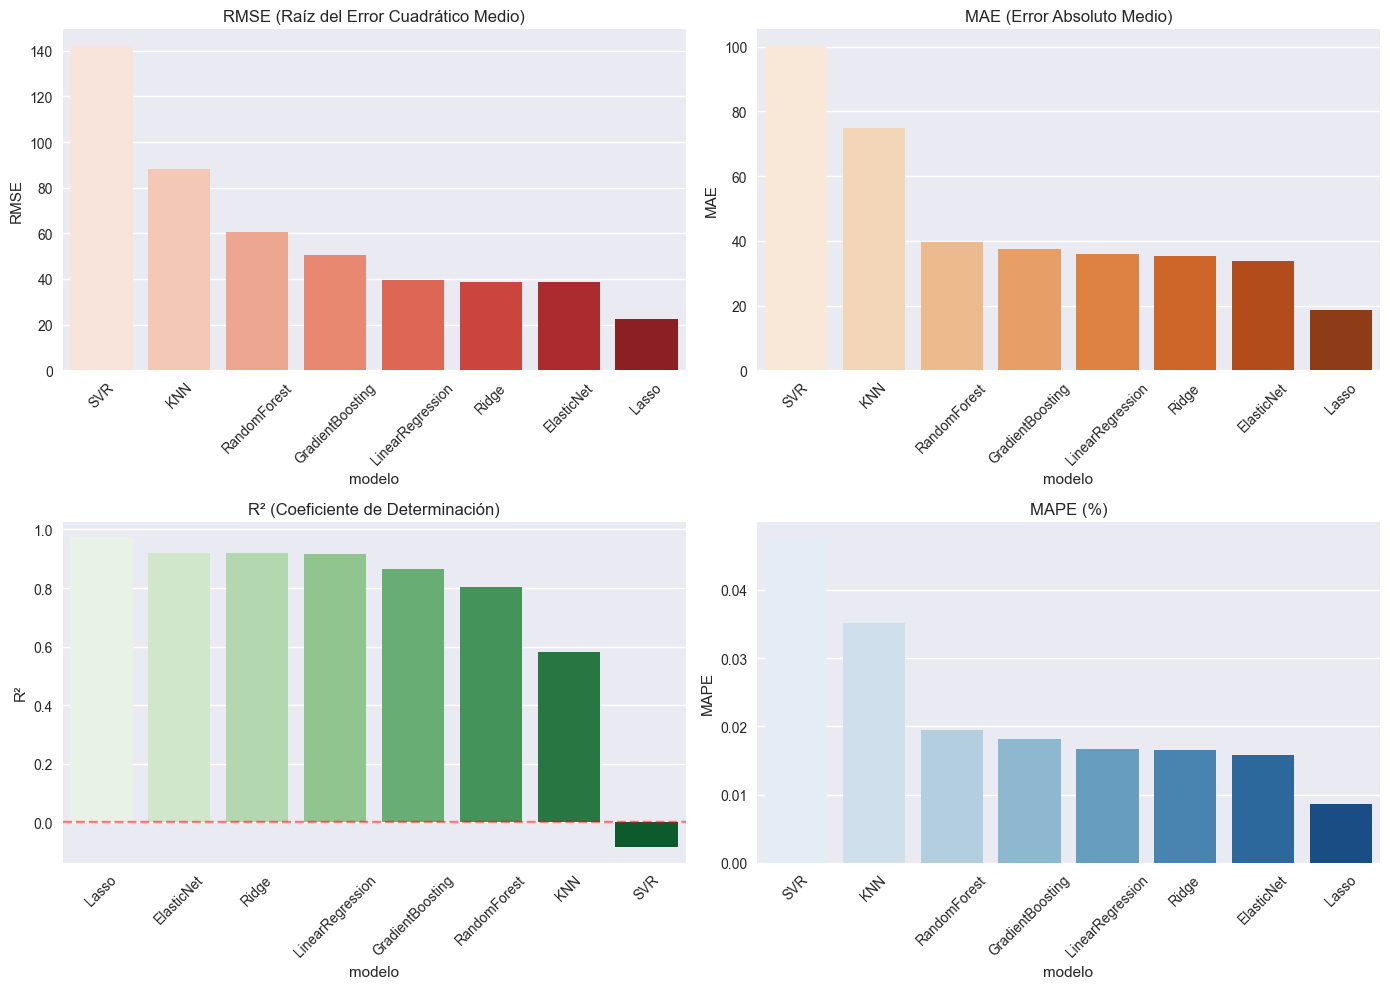


✅ Entrenamiento de modelos de REGRESIÓN completado


In [26]:
# %%
# Preparación para modelos de REGRESIÓN: Target continuo y features
print("🤖 Preparando datos para modelos de REGRESIÓN")
print("=" * 70)

# Verificar que df_main existe y tiene datos
if 'df_main' not in locals():
    raise ValueError("❌ df_main no está disponible. Ejecuta primero las celdas de carga e integración (celdas 1-7).")
    
if df_main.empty:
    raise ValueError("❌ df_main está vacío. Revisa las celdas anteriores para asegurarte de que los datos se cargaron correctamente.")

df_integrado = df_main.copy()
print(f"✅ Dataset cargado: {df_integrado.shape[0]} filas, {df_integrado.shape[1]} columnas")
print(f"   Columnas disponibles: {len(df_integrado.columns)}")

# Identificar columna objetivo continua (variable a predecir)
possible_targets = ['p50', 'consumo_per_capita', 'consumo', 'target_continuo']
target_cont = None
for target_name in possible_targets:
    if target_name in df_integrado.columns:
        # Verificar que no esté completamente vacío
        if not df_integrado[target_name].isna().all():
            target_cont = target_name
            break

if target_cont is None:
    # Buscar cualquier columna numérica que parezca consumo
    numeric_cols_consumo = df_integrado.select_dtypes(include=[np.number]).columns
    for col in numeric_cols_consumo:
        if 'consumo' in col.lower() or 'p50' in col.lower() or 'p25' in col.lower():
            if not df_integrado[col].isna().all():
                target_cont = col
                print(f"⚠️ Usando '{col}' como target (no se encontró ningún target estándar)")
                break

if target_cont is None:
    raise ValueError(f"No se encontró columna objetivo continua. Columnas disponibles: {list(df_integrado.columns[:20])}")

print(f"✅ Target seleccionado: {target_cont}")
print(f"   Valores únicos: {df_integrado[target_cont].nunique()}")
print(f"   Rango: [{df_integrado[target_cont].min():.2f}, {df_integrado[target_cont].max():.2f}]")
print(f"   Media: {df_integrado[target_cont].mean():.2f}, Mediana: {df_integrado[target_cont].median():.2f}")

# Excluir SOLO la variable objetivo y columnas de identificación únicas
excluded_cols = set([
    target_cont,  # Variable objetivo
    'distrito_num'
])
# Seleccionar TODAS las columnas disponibles excepto las excluidas
# También excluir columnas que son completamente nulas o sin variación
feature_cols = [c for c in df_integrado.columns
                if c not in excluded_cols
                and not df_integrado[c].isna().all()  # Excluir solo si TODAS las filas son NaN
                and df_integrado[c].nunique() > 0]  # Excluir si no tiene valores únicos

print(f"\n✅ Features seleccionadas: {len(feature_cols)} de {len(df_integrado.columns)} columnas totales")
print(f"   Columnas excluidas: {len(excluded_cols)} (target + identificadores únicos)")

# Identificar tipos de columnas antes de usarlas
numeric_cols = [c for c in feature_cols if df_integrado[c].dtype in [np.number, 'int64', 'float64'] or pd.api.types.is_numeric_dtype(df_integrado[c])]
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print(f"   - Numéricas: {len(numeric_cols)}")
print(f"   - Categóricas: {len(categorical_cols)}")

# Preparar X e y (REGRESIÓN: y es continua, no categórica)
X = df_integrado[feature_cols].copy()
y = df_integrado[target_cont].copy()  # Variable continua

# Manejar valores nulos en features numéricas
if len(numeric_cols) > 0:
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Manejar valores nulos en el target
if y.isna().any():
    print(f"⚠️ Advertencia: {y.isna().sum()} valores nulos en el target. Eliminando...")
    mask = ~y.isna()
    X = X[mask].copy()
    y = y[mask].copy()

# Verificar que tenemos suficientes datos
if len(X) < 10:
    raise ValueError(f"⚠️ Muy pocos datos: solo {len(X)} observaciones. Se necesitan al menos 10.")

# Partición train/test (sin stratify para regresión)
test_size = 0.25 if len(df_integrado) > 40 else 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, shuffle=True
)

print(f"\n✅ Datos preparados:")
print(f"   Train: {len(X_train)} observaciones")
print(f"   Test: {len(X_test)} observaciones")

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),  # Con media para regresión
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols),
    ],
    remainder='drop'
)

# MODELOS DE REGRESIÓN
regressors = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=min(5, len(X_train)//3))
}

print(f"\n🤖 Entrenando {len(regressors)} modelos de REGRESIÓN...")

results = []
for name, reg in regressors.items():
    try:
        pipe = Pipeline(steps=[('prep', preprocessor), ('reg', reg)])
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        
        # Métricas de regresión
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # MAPE (evitar división por cero)
        mape = mean_absolute_percentage_error(y_test, y_pred) if (y_test != 0).all() else np.nan
        
        results.append({
            'modelo': name, 
            'RMSE': rmse, 
            'MAE': mae, 
            'R²': r2, 
            'MAPE': mape
        })
        print(f"   ✅ {name}: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.3f}")
    except Exception as e:
        print(f"   ❌ {name}: Error - {e}")
        results.append({
            'modelo': name, 
            'RMSE': np.nan, 
            'MAE': np.nan, 
            'R²': np.nan, 
            'MAPE': np.nan
        })

results_df = pd.DataFrame(results).sort_values('RMSE', ascending=True, na_position='last')
print(f"\n📊 Resultados de REGRESIÓN (ordenados por RMSE):")
print(results_df.to_string())

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
if not results_df.empty:
    # RMSE (menor es mejor)
    order_rmse = results_df.sort_values('RMSE', ascending=False)['modelo']
    sns.barplot(data=results_df, x='modelo', y='RMSE', order=order_rmse, palette='Reds', ax=axes[0, 0])
    axes[0, 0].set_title('RMSE (Raíz del Error Cuadrático Medio)')
    axes[0, 0].tick_params(axis='x', rotation=45)

    # --- MAE (menor es mejor) ---
    order_mae = results_df.sort_values('MAE', ascending=False)['modelo']
    sns.barplot(data=results_df, x='modelo', y='MAE', order=order_mae, palette='Oranges', ax=axes[0, 1])
    axes[0, 1].set_title('MAE (Error Absoluto Medio)')
    axes[0, 1].tick_params(axis='x', rotation=45)

    # --- R² (mayor es mejor) ---
    order_r2 = results_df.sort_values('R²', ascending=False)['modelo']
    sns.barplot(data=results_df, x='modelo', y='R²', order=order_r2, palette='Greens', ax=axes[1, 0])
    axes[1, 0].set_title('R² (Coeficiente de Determinación)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # --- MAPE (menor es mejor) ---
    results_df_mape = results_df.dropna(subset=['MAPE'])
    if not results_df_mape.empty:
        order_mape = results_df_mape.sort_values('MAPE', ascending=False)['modelo']
        sns.barplot(data=results_df_mape, x='modelo', y='MAPE', order=order_mape, palette='Blues', ax=axes[1, 1])
        axes[1, 1].set_title('MAPE (%)')
        axes[1, 1].tick_params(axis='x', rotation=45)
    else:
        axes[1, 1].text(0.5, 0.5, 'MAPE no disponible', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('MAPE (no disponible)')

plt.tight_layout()
plt.show()
print("\n✅ Entrenamiento de modelos de REGRESIÓN completado")



In [27]:
# %%
# Validación cruzada + GridSearch para REGRESIÓN
print("🔍 Validación Cruzada y Grid Search - REGRESIÓN")
print("=" * 70)

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer

# Verificar que df_integrado existe y tiene datos
if 'df_integrado' not in locals() or df_integrado.empty:
    raise ValueError("❌ df_integrado no está disponible o está vacío. Ejecuta primero la celda 9 (preparación de datos).")

# Verificar que tenemos las variables necesarias
if 'preprocessor' not in locals() or 'X_train' not in locals() or 'X_test' not in locals():
    raise RuntimeError('⚠️ Ejecuta primero la celda 9 de preparación y entrenamiento de modelos.')

# Ajustar número de folds según tamaño del dataset (KFold para regresión)
n_splits = min(5, len(X_train) // 2) if len(X_train) < 20 else 5
if n_splits < 2:
    print("⚠️ Muy pocos datos para validación cruzada. Usando solo evaluación en test.")
    n_splits = 2

cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
scorers = {
    'neg_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
    'r2': make_scorer(r2_score),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False)
}

print(f"📊 Configuración CV: {n_splits} folds")
print(f"   Train size: {len(X_train)}, Test size: {len(X_test)}")

# Grids de parámetros para regresión (reducidos si hay pocos datos)
param_grids = {
    'RandomForest': {
        'reg__n_estimators': [100, 300] if len(X_train) < 30 else [200, 400],
        'reg__max_depth': [None, 5] if len(X_train) < 30 else [None, 5, 10],
        'reg__min_samples_split': [2, 5]
    },
    'SVR': {
        'reg__C': [0.5, 1, 5] if len(X_train) < 30 else [0.5, 1, 5, 10],
        'reg__gamma': ['scale', 0.1] if len(X_train) < 30 else ['scale', 0.1, 0.01],
        'reg__kernel': ['rbf']
    },
    'GradientBoosting': {
        'reg__n_estimators': [100, 200] if len(X_train) < 30 else [100, 200, 300],
        'reg__learning_rate': [0.05, 0.1] if len(X_train) < 30 else [0.05, 0.1, 0.2],
        'reg__max_depth': [2, 3]
    },
    'Ridge': {
        'reg__alpha': [0.1, 1.0, 10.0] if len(X_train) < 30 else [0.1, 1.0, 10.0, 100.0]
    },
    'ElasticNet': {
        'reg__alpha': [0.1, 0.5, 1.0],
        'reg__l1_ratio': [0.3, 0.5, 0.7]
    }
}

search_results = []
best_pipes = {}

for name in ['RandomForest', 'SVR', 'GradientBoosting', 'Ridge', 'ElasticNet']:
    if name not in regressors:
        print(f"⚠️ {name} no está en regressors. Saltando...")
        continue
        
    print(f"\n🔍 Grid Search para {name}...")
    try:
        base_reg = regressors[name]
        pipe = Pipeline(steps=[('prep', preprocessor), ('reg', base_reg)])
        
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grids[name],
            scoring='neg_mean_squared_error',  # Para regresión, menor error es mejor
            refit=True,
            cv=cv,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_train, y_train)
        best_pipes[name] = grid.best_estimator_
        cv_rmse = np.sqrt(-grid.best_score_)  # Negativo porque usamos neg_mean_squared_error
        
        # Evaluación en test
        y_pred = grid.best_estimator_.predict(X_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        mae_test = mean_absolute_error(y_test, y_pred)
        r2_test = r2_score(y_test, y_pred)
        
        print(f"   ✅ Mejores parámetros: {grid.best_params_}")
        print(f"   📊 CV RMSE: {cv_rmse:.2f}, Test RMSE: {rmse_test:.2f}, Test MAE: {mae_test:.2f}, Test R²: {r2_test:.3f}")
        
        search_results.append({
            'modelo': name, 
            'cv_rmse': cv_rmse, 
            'test_rmse': rmse_test, 
            'test_mae': mae_test,
            'test_r2': r2_test
        })
    except Exception as e:
        print(f"   ❌ Error en {name}: {e}")
        import traceback
        print(f"   Detalles: {traceback.format_exc()[:200]}")
        search_results.append({
            'modelo': name, 
            'cv_rmse': np.nan, 
            'test_rmse': np.nan, 
            'test_mae': np.nan,
            'test_r2': np.nan
        })

if search_results:
    cv_df = pd.DataFrame(search_results).sort_values('test_rmse', ascending=True, na_position='last')
    print(f"\n📊 Resultados de Grid Search (ordenados por Test RMSE):")
    print(cv_df.to_string())
else:
    cv_df = pd.DataFrame()
    print("⚠️ No se completó ningún grid search.")


🔍 Validación Cruzada y Grid Search - REGRESIÓN
📊 Configuración CV: 5 folds
   Train size: 14, Test size: 7

🔍 Grid Search para RandomForest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   ✅ Mejores parámetros: {'reg__max_depth': None, 'reg__min_samples_split': 5, 'reg__n_estimators': 100}
   📊 CV RMSE: 152.41, Test RMSE: 67.41, Test MAE: 44.59, Test R²: 0.756

🔍 Grid Search para SVR...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
   ✅ Mejores parámetros: {'reg__C': 5, 'reg__gamma': 'scale', 'reg__kernel': 'rbf'}
   📊 CV RMSE: 200.79, Test RMSE: 141.13, Test MAE: 99.86, Test R²: -0.068

🔍 Grid Search para GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
   ✅ Mejores parámetros: {'reg__learning_rate': 0.05, 'reg__max_depth': 2, 'reg__n_estimators': 200}
   📊 CV RMSE: 135.92, Test RMSE: 51.72, Test MAE: 38.34, Test R²: 0.857

🔍 Grid Search para Ridge...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
   ✅ Mejores 

📊 Visualizaciones del mejor modelo de REGRESIÓN
✅ Mejor modelo (test RMSE): ElasticNet

📊 Métricas finales en TEST:
   RMSE: 37.88
   MAE: 31.43
   R²: 0.923


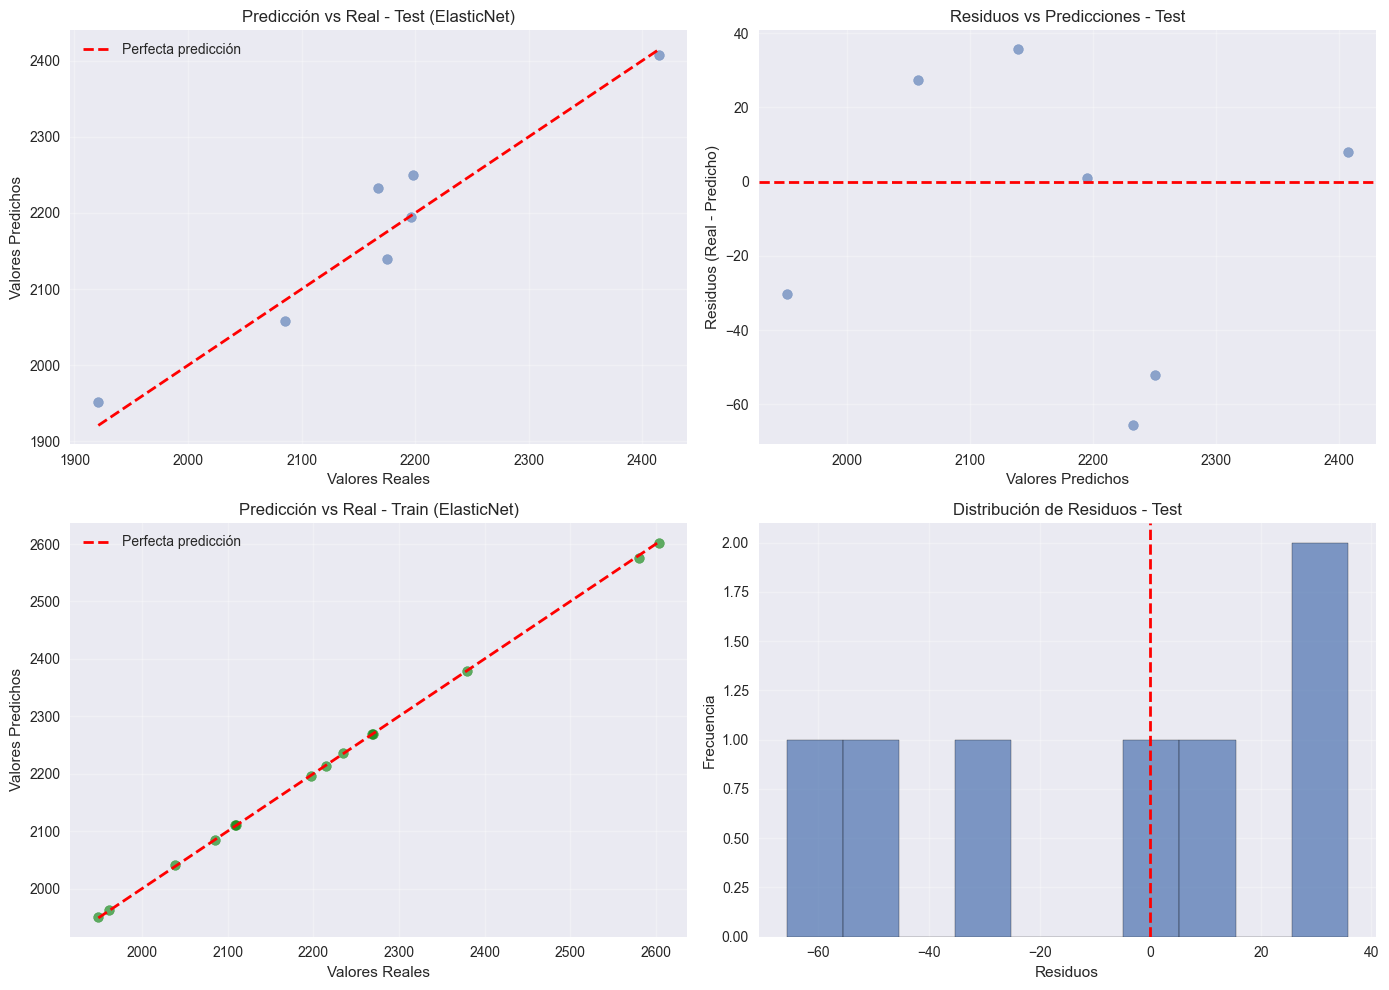


✅ Visualizaciones completadas


In [28]:
# %%
# Visualizaciones de REGRESIÓN: Predicción vs Real y Residuos
print("📊 Visualizaciones del mejor modelo de REGRESIÓN")
print("=" * 70)

if cv_df.empty or len(cv_df) == 0:
    best_name = results_df.iloc[0]['modelo']
    best_pipe = Pipeline(steps=[('prep', preprocessor), ('reg', regressors[best_name])])
    best_pipe.fit(X_train, y_train)
    print(f"⚠️ Usando mejor modelo del entrenamiento inicial: {best_name}")
else:
    best_row = cv_df.iloc[0]
    best_name = best_row['modelo']
    best_pipe = best_pipes[best_name]
    print(f"✅ Mejor modelo (test RMSE): {best_name}")

# Predicciones
y_pred_best = best_pipe.predict(X_test)
y_train_pred = best_pipe.predict(X_train)

# Métricas finales
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_test = mean_absolute_error(y_test, y_pred_best)
r2_test = r2_score(y_test, y_pred_best)

print(f"\n📊 Métricas finales en TEST:")
print(f"   RMSE: {rmse_test:.2f}")
print(f"   MAE: {mae_test:.2f}")
print(f"   R²: {r2_test:.3f}")

# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicción vs Real (Test)
axes[0, 0].scatter(y_test, y_pred_best, alpha=0.6, s=50)
min_val = min(y_test.min(), y_pred_best.min())
max_val = max(y_test.max(), y_pred_best.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfecta predicción')
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Valores Predichos')
axes[0, 0].set_title(f'Predicción vs Real - Test ({best_name})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuos vs Predicciones (Test)
residuos = y_test - y_pred_best
axes[0, 1].scatter(y_pred_best, residuos, alpha=0.6, s=50)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Valores Predichos')
axes[0, 1].set_ylabel('Residuos (Real - Predicho)')
axes[0, 1].set_title('Residuos vs Predicciones - Test')
axes[0, 1].grid(True, alpha=0.3)

# 3. Predicción vs Real (Train)
axes[1, 0].scatter(y_train, y_train_pred, alpha=0.6, s=50, color='green')
min_val_train = min(y_train.min(), y_train_pred.min())
max_val_train = max(y_train.max(), y_train_pred.max())
axes[1, 0].plot([min_val_train, max_val_train], [min_val_train, max_val_train], 'r--', lw=2, label='Perfecta predicción')
axes[1, 0].set_xlabel('Valores Reales')
axes[1, 0].set_ylabel('Valores Predichos')
axes[1, 0].set_title(f'Predicción vs Real - Train ({best_name})')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribución de residuos
axes[1, 1].hist(residuos, bins=10, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Residuos')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribución de Residuos - Test')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Visualizaciones completadas")



In [29]:
# %%
# Guardar resultados CV y figuras
if not cv_df.empty:
    cv_path = DATA_DIR / 'regresion_cv_resultados.csv'
    cv_df.to_csv(cv_path, index=False)
    print(f"✅ Resultados CV de REGRESIÓN guardados -> {cv_path}")
else:
    print("⚠️ No hay resultados de CV para guardar")



✅ Resultados CV de REGRESIÓN guardados -> C:\Users\phoen\Desktop\TFM\data\processed\regresion_cv_resultados.csv
